# Select wildfire burn area predictors, train a classifier, & make predicitons. 

- This will be done using the Lasso (L1 Norm), which will be implemented using sk-learn sklearn.linear_model.Lasso()
- The Lasso() has a single hyperparameter, $\alpha$, which I will selected using nested leave-one-out cross validation via sklearn.model_selection.LeaveOneOut, the best model will be chosen using sklearn.model_selection.GridSearchCV()
- Environmental variables to be used as features include:
    - Near surface temperature (tas) 
    - Total Precipitation (Tp) 
    - RH% (hurs), near surface wind speed (ScfWind) 
    - vapor pressure deficit (VPD) 
    - evaporation (evspsbl), 
    - total soil moisture content (mrso) 
    - and latent heat flux (hfls)  
- All reanalysis data used to train the model as well as CMIP5 output to project are monthly means (e.g. Temperature) or totals (e.g. Precipitation). For training and predictions, seasonal mean and totals of the predictors will be created, including lagged predictors. $e.g.$ winter precip will be calculated and used to predict summer wildfire burn area.  


#### TODO: 
- If you can't get the skill up
- Limit the number of predictors based on those with a descent correlation
- Try a smaller area? 

In [204]:
%matplotlib inline
import numpy as np
from netCDF4 import Dataset
import os
#%config InlineBackend.figure_format = 'svg' # For higher resolution figures
import matplotlib.pyplot as plt
import os
import time
import pandas as pd
import model_dictionary as md # Modules I have written 
from sklearn import preprocessing # For scaling data 
import met_spread_utils as utils # Script full of methods required for this analysis. 
from shapely.geometry import Polygon, Point
import geopandas
import pickle

### List the environmental variables to be used to explain historical variance in fire and predict in the future. 
#### Separate into atmos and plant centric based on Swann et al 2016. 

In [2]:
predictors = ["t2m", "tp", "si10", "RH", "slhf", "VPD", "mrso", "e"] # all variables for prediction era names 
plant_vars = ['pr', 'mrso','hfls', 'evspsbl'] # plant centric for prediction, CMIP5 names 
atmos_vars = ['tas', 'VPD', 'hurs', 'sfcWind'] # atmos centric prediction, CMIP5 names

# The months of burn area to be analyzed (predicted) using the predictors listed above
# and converted to seasonal means. 
burn_area_season = [6,7,8]

In [3]:
# Set important paths
CMIP5_dir = os.path.join("..", "Data", "CMIP5", "r1i1p1_rcp_COMMON_GRID")
era_dir   = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
fire_file = os.path.join("..","Data","Fire", "MTBS", "bailys_division_acres_burned.csv")

Create or set a directory relevent to these experimental settings. The Directory will be a self contained location that holds all results associated with this script
- Data generated (correlations) as well structures arrays
- Figures associated with regressions and analysis
- This will make a self contained area so that I know what code made what data and what figures go with those.

In [60]:
# For now, call it beta
save_dir_base = os.path.join("..", "Data", "Analysis", "beta")

if not os.path.isdir(save_dir_base) : 
    os.mkdir(save_dir_base)

### Load the Baileys divisions used to subset ecoregions in this analysis 
- Note: Marine Regime Mountains division goes along the coast of Alaska, but the burn area has been exluded there, so exlude in plotting here and later in meteorology. 

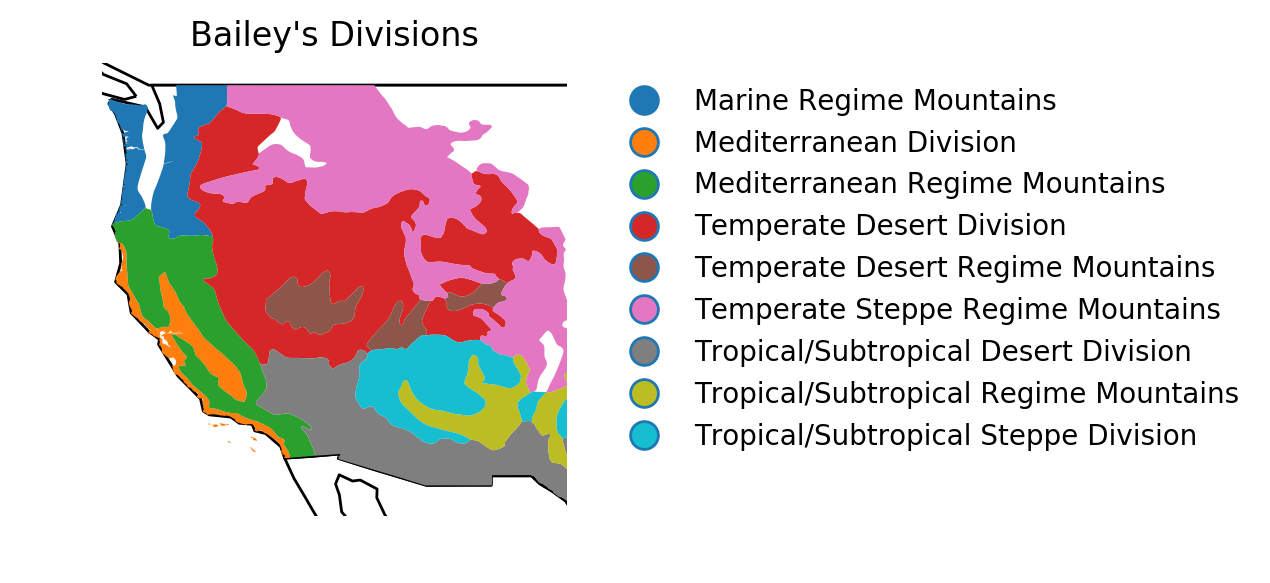

In [6]:
# Load US ecoregions and plot the united states land mass together
eco_dir = os.path.join("..", "Data", "LandCover", "eco-us-shp")
eco_shp = geopandas.read_file(eco_dir)
eco_shp = eco_shp.to_crs({'init': '+init=epsg:4326'})

# For political borders (plotting)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.to_crs({'init': '+init=epsg:4326'})

# Western US divisions to be included in this analysis 
desired_divisions = ["Temperate Steppe Regime Mountains", 
                     "Marine Regime Mountains", 
                     #'Marine Division', # No burn area! So will exclude
                     "Mediterranean Regime Mountains", # includes southern coastal Alaska sections
                     "Mediterranean Division",
                     'Temperate Desert Division',
                     "Tropical/Subtropical Steppe Division",
                     'Tropical/Subtropical Desert Division',
                     'Tropical/Subtropical Regime Mountains',
                     'Temperate Desert Regime Mountains',
                    ]

# Make a mask of the desired divisions
division_mask = eco_shp.DIVISION.isin(desired_divisions)
eco_shp_subset = eco_shp.loc[np.array(division_mask),:].copy()

# Join by common division, first subset to AREA and division only, make copy
section_rows = eco_shp_subset[['DIVISION', 'AREA', 'geometry']].copy()
geo_divisions = section_rows.dissolve(by='DIVISION', aggfunc='sum')

# Make row names a column (attribute)
geo_divisions['division'] = geo_divisions.index

# Show the selected divisions 
f, ax = plt.subplots(1, figsize=(3, 3), dpi=200)
base = world.plot(ax=ax, color="white", edgecolor="black")
ax1 = geo_divisions.plot(ax=base, column='division', legend=True)
ax.set_xlim(left=-125, right=-105)
ax.set_ylim(bottom=30, top=50)
ax.axis('off')
plt.title("Bailey's Divisions")

# handle the legend
leg = ax1.get_legend()
leg.set_bbox_to_anchor((1, 1, 1.5, 0.0))
leg.set_frame_on(False)
plt.show()

### Get the desired burn area data for the chosen divisions

In [8]:
# Read in burn area, in acres
fire_df = pd.read_csv(fire_file)

# subset by the desired divisions
division_mask = fire_df.columns.isin(desired_divisions)
print("--------------------------------")
print("Divisions used in this analysis:")
print("--------------------------------")

fire_df_subset = fire_df.loc[:,np.array(division_mask)].copy()

# MTBS data start Jan 1984, are monthly, and end in 2017. Make
# a time array date_range that matches this. 
time_mtbs = pd.date_range("1984-01-01", periods=len(fire_df), freq="M")

# Make the monthly time series the row index for the division fire data 
fire_df_subset.index = time_mtbs.copy()

fire_df = fire_df_subset.copy()
divisions = np.array(fire_df.columns)
del(fire_df_subset)
print(divisions)

--------------------------------
Divisions used in this analysis:
--------------------------------
['Temperate Steppe Regime Mountains' 'Marine Regime Mountains'
 'Temperate Desert Division' 'Tropical/Subtropical Desert Division'
 'Tropical/Subtropical Steppe Division'
 'Tropical/Subtropical Regime Mountains' 'Mediterranean Regime Mountains'
 'Mediterranean Division' 'Temperate Desert Regime Mountains']


### Show a timeseries of division burn area

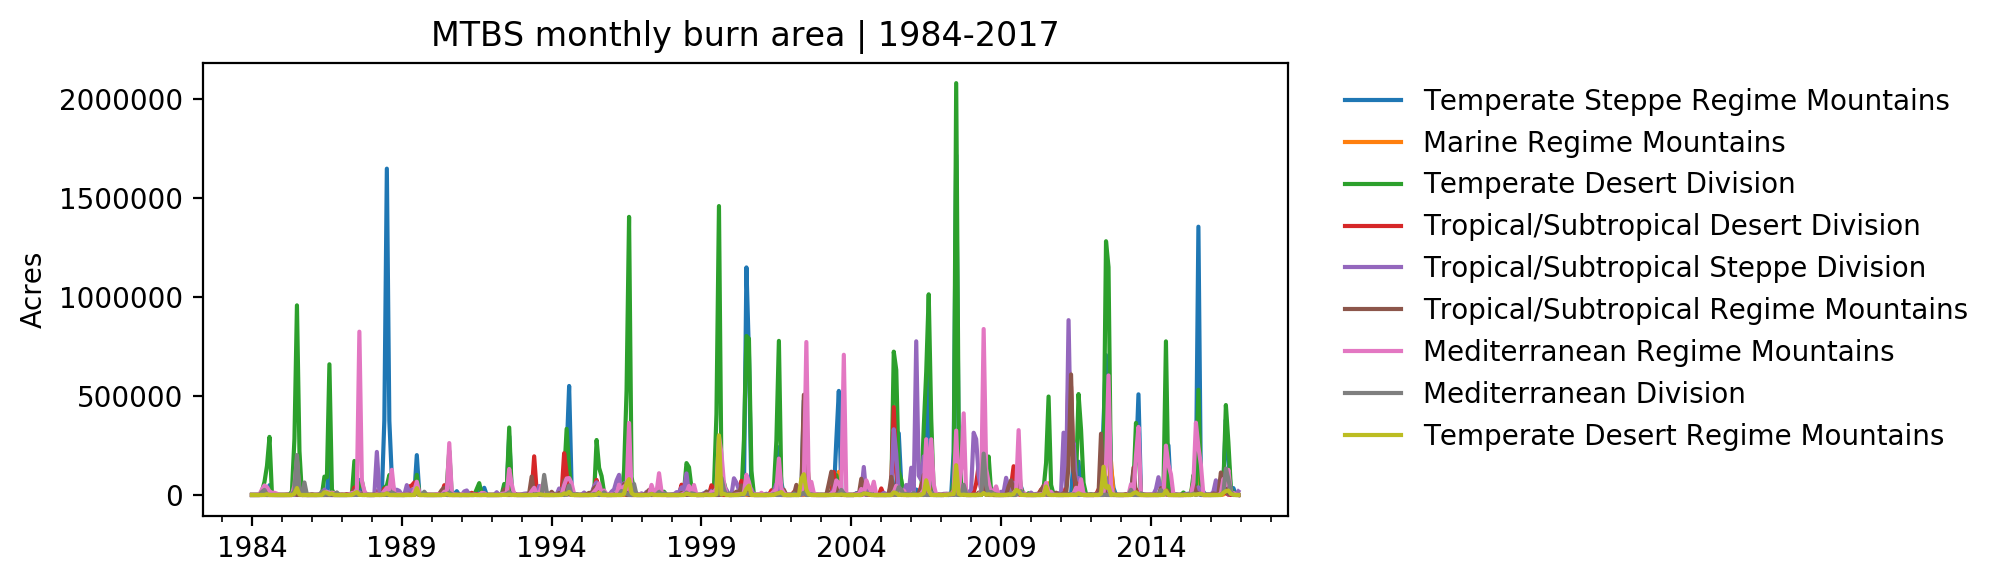

In [9]:
# Show the disolved divisions 
f, ax = plt.subplots(1, figsize=(7, 3), dpi=200)
#plt.plot(time_mtbs, BA)
ax1 = fire_df.plot(ax=ax)
plt.title("MTBS monthly burn area | 1984-2017")
plt.ylabel("Acres")

# handle the legend
leg = ax1.get_legend()
leg.set_bbox_to_anchor((0.15, 1, 1.5, 0.0))
leg.set_frame_on(False)

plt.show()

# Get Bailey's region corrosponding meteorology grids
- We make the assumption that the burn area in the baily's regions mapped above is driven my meteorology over the same spatial region. ERA-interim met (for training) and CMIP5 (for future projections) have been gridded to a common grid and I have figured out what grid boxes overlap what Bailey's divisions. 
- The following code gets masks for each bailey's division within the desired_divisions array. This allows us to subset the gridded meteorology for only the grid boxes that overlap the spatial area of interest. The spatial overlaps and mask creation was done with Python/create_ecoregion_overlap_masks.ipynb

In [10]:
# I need to know what met grid cells to keep with these divisions. Find which ones overlap. 
grid_division_masks_file = os.path.join("..", "Data", "LandCover", "bailys_division_masks_common_grid.nc")
nc = Dataset(grid_division_masks_file, 'r')

grid_lat = nc.variables['lat'][:].data
grid_lon = nc.variables['lon'][:].data

# Use any division grid's shape to set an empty array 
#division_mask = np.zeros(shape=nc.variables[divisions[0]][:].data.shape)

#for division in desired_divisions :
    
#    division_key = division.replace("/", " ")
#    # Where variables are greater than 0, that means that grid box
#    # overlaps the division. That means anywhere where
#    # division_mask > 0 is a grid box we want. 
#    division_mask += nc.variables[division_key][:].data
    
## setup a lat long mask, because we do not want grid boxes for the high latitude
## 'Marine Regime Mountains'
#lat_mask = grid_lat > 50. 
#division_mask[lat_mask,:] = 0

Baily ecoregion map examples

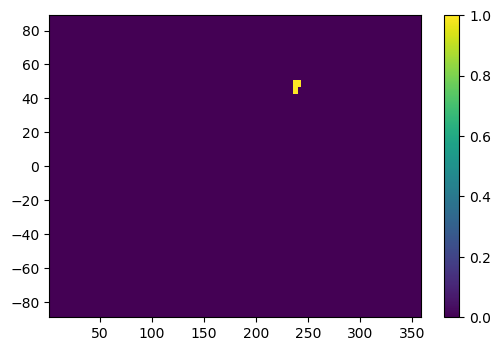

In [11]:
X,Y = np.meshgrid(grid_lon, grid_lat)
plt.figure(dpi=100)
plt.pcolor( X, Y, nc.variables["Marine Regime Mountains"])
plt.colorbar()
plt.show()

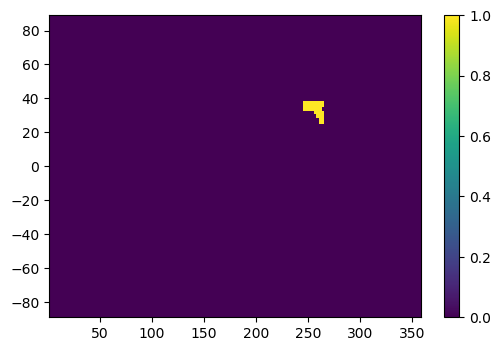

In [12]:
plt.figure(dpi=100)
plt.pcolor( X, Y, nc.variables["Tropical Subtropical Steppe Division"])
plt.colorbar()
plt.show()

What grid boxes overlap any of the ecoregions of interest? 

Function for getting era_nc_vals. Will be moved out of notebook when development is complete

In [13]:
def get_era_nc_variable(var, spatial_mask, spatialMean=False, startYear=1983):
    """
    This function will be for loading a particular nc file, which will be spatially subset.
    The data loaded are from the merged_t_COMMON_GRID directory. These data have been
    regridded from thier native resolution using cdo remapbil. 
    
    TODO: Add "endyear" as an argument in addition to "startyear" as new MTBS fire data is 
    TODO: going to require going further back in time to train the model. 
    
    Parameters
    ----------
        var : str, The variable (and file name) of the ECMWF era-interim data to be 
              loaded. 
        spatial_mask : numpy array, where equal to 0 are locations to keep data for and 
                       where equal to 1 (True) are grid points to mask (ignore data). 
        spatialMean : Boolean, if False (default) a spatial mean of the era-interim data
                      is not taken and the data are returned on a t,lon,lat grid. 
                  
    Return
    ------
        valsCut : The chosen "var" as a ndarray(t, lat, lon) or if spatialMean = True
                  ndarray(t). 
        t_monCut : pd.date_range describing the t axis of valsCut. 
        lonCut : longitude ndarray
        latCut : latitude ndarray
    
    """
    
    # Create link to the monthly file
    dataDir = os.path.join("..", "Data", "ERA-INTERIM", "merged_t_COMMON_GRID")
    f = var + "_1983-2017.nc" 
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! 
    if(not os.path.isfile(loadFile)):
        raise ValueError(f + " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Create a new array, where each time slice will be a masked version 
    # of the data loaded from the nc file 
    vals_masked = np.ma.empty(shape=vals.shape)
    
    # Pandas handling of time so all models have the exact same origin and such. 
    t = nc.variables["time"]
    if(len(t) == 420):
        # Convert to pandas time array, on the assumption t[0]=startYear-01-01 the data
        # being monthly. Defualt files are 1983-2017.  
        t_mon = pd.date_range(str(startYear)+"-01-01", periods=len(t), freq="M")
    else:
        # there should always be 420 months in these data (35 years of data times 12)
        raise ValueError('Error in number of months for file: '+ f + " 420 expected.")
        
    # Now subset the data based on the passed spatial_mask
    for i in range(len(t)) : 
        vals_masked[i,:,:] = np.ma.masked_array(vals[i,:,:], mask=spatial_mask, copy=True)
    
    # take a spatial mean? 
    if spatialMean:
        # Masked entries are ignored
        vals_masked = np.ma.mean(vals_masked, axis=(1,2))
    
    return vals_masked, t_mon, lon, lat

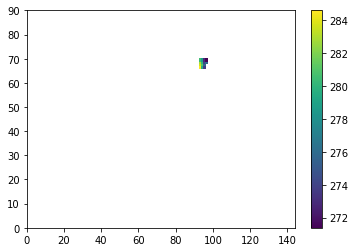

In [14]:
# Demonstrate that the masked array masks data outside of area of interst
t2m, t, lon, lat = get_era_nc_variable('t2m', nc.variables["Marine Regime Mountains"][:]==0)
plt.pcolor(t2m[0,:,:])
plt.colorbar()
plt.show()

### Load desired ERA-Interim reanalysis
- Load each variable, take the spatial mean for the spatial_masks shown above and place in a dataframe where each row is a month and each column is a variable, each cell is a monthly mean value for the area. 

In [15]:
def get_division_era_variables(predictors, spatial_mask) : 
    """
    This script employs get_era_nc_variable() and loads the desired predictors 
    for a given ecoregion (division). The spatial mask needs to be passed. The
    spatial me of the data for a given division is taken when using this method
    because it returns a dataframe where the columns are the predictors and the 
    rows are the spatially average monthly-mean values. 
    
    Parameters
    ----------
        predictors : list, the era-interim variables to load. 
        spatial_mask : numpy.ndarray containing True and False values only. Values
                       are true for grid boxes not desired (to be used as masked) 
                       and values are False for the area with data to be averaged
                       spatially. 
    
    return
    ------
        A pd.DataFrame where the columns are the predictors and the 
        rows are the spatially average monthly-mean values. 
        
    """

    predictorDict = {}

    for var in predictors :

        predictorDict[var], t, lon, lat = get_era_nc_variable(var, spatial_mask, spatialMean=True)

    # Features used to estimate the target function    
    X_monthly = pd.DataFrame(predictorDict, index=t)
    
    return X_monthly 

In [16]:
# Dictionary to store monthly values for predictors (era data)
X_monthly_dict = {}

for div in divisions : 
    
    # Remove forbiden charactors 
    division_key = div.replace("/", " ")
    #print(division_key)
    # NOTE: The division masks are stored such that 1 means in division, 0 means not.
    # NOTE: np.ma masking requires a true or 1 for values to mask, i.e. ignore, so 
    # NOTE: the data from the nc file for divisions is flipped when getting division 
    # NOTE: data 
    print(division_key)
    div_mask = nc.variables[division_key][:].data == 0
    X_monthly_dict[div] = get_division_era_variables(predictors, div_mask)
    #print(np.sum(X_monthly_dict[div].tp))
    
nc.close()

Temperate Steppe Regime Mountains
Marine Regime Mountains
Temperate Desert Division
Tropical Subtropical Desert Division
Tropical Subtropical Steppe Division
Tropical Subtropical Regime Mountains
Mediterranean Regime Mountains
Mediterranean Division
Temperate Desert Regime Mountains


### Change units of some ERA-Interim data to match CMIP5 output

#### Evaporation
- evaporation, e, is m mon$^{-1}$, want to match evspsbl is $kgm^{-2}s^{-1}$
- precipitation

$$evspsbl_{era-interim} = e(\frac{m}{mon})\times1000(\frac{kg}{m^{3}})\times\frac{1mon}{30day}\times\frac{1day}{86400s}$$

#### Total Precipitation
- Total precip, tp, is m mon$^{-1}$, want to match tp$_{CMIP5}$ ($kgm^{-2}s^{-1}$)

$$tp^{'} = tp(\frac{m}{mon})\times1000(\frac{kg}{m^{3}})\times\frac{1mon}{30day}\times\frac{1day}{86400s}$$


#### Surface latent heat flux
- ERA-interim slhf as J $m^{-2}$ (very negative for the Gulf Stream)
- CMIP5 : hfls (surface upward latent heat flux) as W $m^{-2}$ (very positive over Gulf Stream)

$$W=\frac{J}{s}=kg m^{2} s^{-1}$$


$$hfls_{era-interim} = slhf(J m^{-2}) \times \frac{1}{mon} \times \frac{mon}{s} = slhf(J m^{-2})\times \frac{1mon}{30day}\times\frac{1day}{86400s}$$

### TODO: 
- Do I need to account for different number of days in months?
- Get rid of the factor of two after new fixed data are ready. 

In [17]:
def m_to_mass_flux(tp_m) :
    """
    This function takes mean total precipitation in meters [m] and converts to a mass flux. 
    https://confluence.ecmwf.int/pages/viewpage.action?pageId=65218804
    Incoming tp_m argument must have units of mean m/day. Multiplication by the density
    of water, 1 mon per 30 days, 1 day per 86400 seconds are used to obtain units
    of kg m**-2 s**-1, the so-called tp_prime value that is returned. 
    Will work anytime meters of water per month needs to be converted to kg/m**2/s
    """
    
    density = 1000. # kg m**-3
    #nYears = len(np.arange(1983,2017+1))
    #days_per_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    #seconds_per_month = days_per_month * 24. * 60**2
    # Same length as tp_m
    #seconds_per_all_months = np.repeat(seconds_per_month, nYears) 
    seconds_per_day = 86400. 
    tp_prime     = tp_m * density / seconds_per_day
    
    return tp_prime

def J_flux_to_W_flux(slhf) :
    """
    https://confluence.ecmwf.int/pages/viewpage.action?pageId=65218804
    Converts a flux of J m**-2 month**-1 to W m**-2 month**-1
    """
    #nYears = len(np.arange(1983,2017+1))
    #days_per_month = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    #seconds_per_month = days_per_month * 24. * 60**2
    #seconds_per_all_months = np.repeat(seconds_per_month, nYears)
    # The minus one is to make the sign of the flux over the gulf current match
    seconds_per_day = 86400. 
    hfls_era_interim = slhf / seconds_per_day / 2. * -1 # temp factor of dividing by 2. 
    
    return hfls_era_interim

#### Convert units on fields that need it 

In [19]:
print(predictors)

['t2m', 'tp', 'si10', 'RH', 'slhf', 'VPD', 'mrso', 'e']


In [20]:
for div in divisions : 
    
    # Get a regions met values to change units for 
    X_monthly = X_monthly_dict[div]
    
    tp = m_to_mass_flux( np.array(X_monthly["tp"].copy()) )
    e = m_to_mass_flux( np.array(X_monthly["e"].copy()) ) * -1.
    slhf = J_flux_to_W_flux( np.array(X_monthly["slhf"].copy()) )
    
    # Replace columns with updated versions
    X_monthly.loc[:, "tp"] = tp
    X_monthly["e"] = e 
    X_monthly["slhf"] = slhf
    
    # Finally, make the names of the era-interim variables match the names
    # in CMIP5 output. After this step, the units and names should match. 
    # t2m tp si10 RH slhf VPD mrso e
    X_monthly.rename(columns={"t2m":"tas","tp":"pr","si10":"sfcWind","RH":"hurs", 
                              "slhf":"hfls", "VPD":"VPD", "mrso":"mrso", "e":"evspsbl"}, 
                     inplace=True)
    
    # Place back in dictionary 
    X_monthly_dict[div] = X_monthly
    #print(X_monthly.columns)

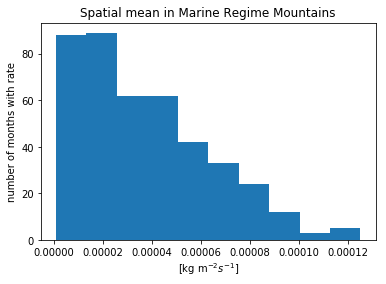

In [21]:
#plt.figure()
#plt.plot(X_monthly_dict['Marine Regime Mountains'].pr, tp_mass_flux)
#plt.xlabel("pr [m]")
#plt.ylabel("pr [kg m$^{-2}s^{-1}$]")
#plt.suptitle("ERA-Interim total precipitation (tp) meters to mass flux ratio")
#plt.title("(Should be linear)")
#plt.show()

plt.figure()
plt.hist(X_monthly_dict['Marine Regime Mountains'].pr)
plt.xlabel("[kg m$^{-2}s^{-1}$]")
plt.title("Spatial mean in Marine Regime Mountains")
plt.ylabel("number of months with rate")
plt.show()

### Setup forecasting summer burn area using seasonal (varying t-lag) predictors and calculating summer burn area

#### Seasons to aggregate features
- summer (6,7,8)
- spring (3,4,5)
- winter (11,12,1,2) 

TODO: 
- Other previous years seasons? 

In [175]:
def make_monthly_seasonal(X_monthly, time_mtbs, inspect=False) :
    """
    Makes monthly met predictors seasonal by taking monthly predictors (features) 
    to means of seasons, winter=[11,12,1,2], spring=[3,4,5], summer=[6,7,8]. For 
    winter predictor, the months 11 and 12 will come from the previous year, so 
    when making predictors for a row (year) 2013, the months to be averaged are
    Nov 2012, Dec 2012, Jan 2013, Jan 2014. This is all meant to forecast burn area
    occurring in the months 6,7,8 (summer). 
    NOTE: When using this to convert CMIP5 monthly predictors to seasonal, because 
    NOTE: the time_mtbs argument will be cmip time, the first years (1984) _winter
    NOTE: features will be an average of Jan 1984 and Feb 1984, since there is no 
    NOTE: data for the previous year. All other year winter predictors are normal.
    
    Parameters
    ----------
        X_monthly : pd.DataFrame object with shape [months x features] where the index
                    is a datetimes.DatetimeIndex
        time_mtbs : datetimes.DatetimeIndex that matches either monthly burn area series
                    (for era-interim data) or the X_montly.index (for cmip data).
        inspect : When True, the masked time array used for each years seasonal predictors
                  will be printed. 
                  
    return
    ------
        pd.DataFrame : A dataframe [year x seasonal_feature] where each feature in the 
                       X_monthly pd.DataFrame has been expanded to var_winter, var_spring
                       var_summer. 
    """
        
    # Create summer burn area time series
    fire_years  = np.sort(np.unique(time_mtbs.year))
    nYears      = len(fire_years)

    # ERA data starts one year before the burn area data 
    era_time = X_monthly.index.copy()
    era_year = era_time.year
    era_month = pd.Series(era_time.month)

    # Create season masks (first month last month of season). Each season gets its own 
    # column in the features DataFrame.
    # NOTE: Make sure to not use months after wildfires in a given year, e.g. 
    # NOTE: December, unless set to the year before # Make sure to not use months 
    # NOTE: after wildfires in a given year, e.g. December, unless set to the year before 
    seasons = {"winter":[11,12,1,2], 
               "spring":[3,4,5], 
               "summer":[6,7,8]}

    # Make a dictionary to store predictors for each variable for each season 
    # of interest. 
    variables = np.array( X_monthly.columns.copy() )
    
    # To store predictor information 
    predictor_dict = {} 

    for pre in variables :
        for s in seasons.keys() :
            predictor_name = pre + "_" + s 
            predictor_dict[predictor_name] = np.zeros(nYears)

    # Loop through each year, assigning desired season predictor value 
    # within each year 
    for i in range(nYears):
        
        if inspect :
            print(fire_years[i])
        
        # Loop through seasons, within a year
        for s in seasons.keys():
            
            if inspect : 
                print(s)

            if s == 'winter' : 
                
                prev_year_mask = (fire_years[i]-1) == era_year
                m1 = era_month.isin([11,12])
                tChuchk1 = prev_year_mask & m1
                
                this_year_mask = fire_years[i] == era_year
                m2 = era_month.isin([1,2])
                tChuchk2 = this_year_mask & m2
                # Want an array than combines the True locations, "or" in other
                # words 
                tChunk = tChuchk1 | tChuchk2
                
                if inspect :
                    print(era_time[tChunk])
                
            else :
                
                # The non-winter predicors months fall into the same year as fire activity
                year_mask = fire_years[i] == era_year
                
                # Mask the months that fall into the current season of interest
                month_mask = era_month.isin(seasons[s])

                # combine to make a single mask
                tChunk = month_mask & year_mask 
                
                if inspect :
                    print(era_time[tChunk])

            # For each predictor variable, loop through taking relevant stat
            for pre in variables:
                k = pre + "_" + s
                predictor_dict[k][i] = np.mean(X_monthly.loc[era_time[tChunk], pre].copy())
    
    # Return a DataFrame of era data as desired seasonal features 
    return pd.DataFrame(predictor_dict, index=fire_years)

### Make monthly era data into seasonal means for each division 

In [23]:
X_seasonal_dict = {}
for div in divisions : 
    X_seasonal_dict[div] = make_monthly_seasonal(X_monthly=X_monthly_dict[div], time_mtbs=time_mtbs)

### Make monthly burn area data into target season burn area totals 
https://stackoverflow.com/questions/38792122/how-to-group-and-count-rows-by-month-and-year-using-pandas

In [24]:
# Subset rows to burn_area_season, then 
df_= fire_df[fire_df.index.month.isin(burn_area_season)].copy()
# Aggregated by season is the target function, y, so start calling it y. 
y_seanonal_df = df_.groupby(df_.index.year).agg('sum').copy()
del(df_)

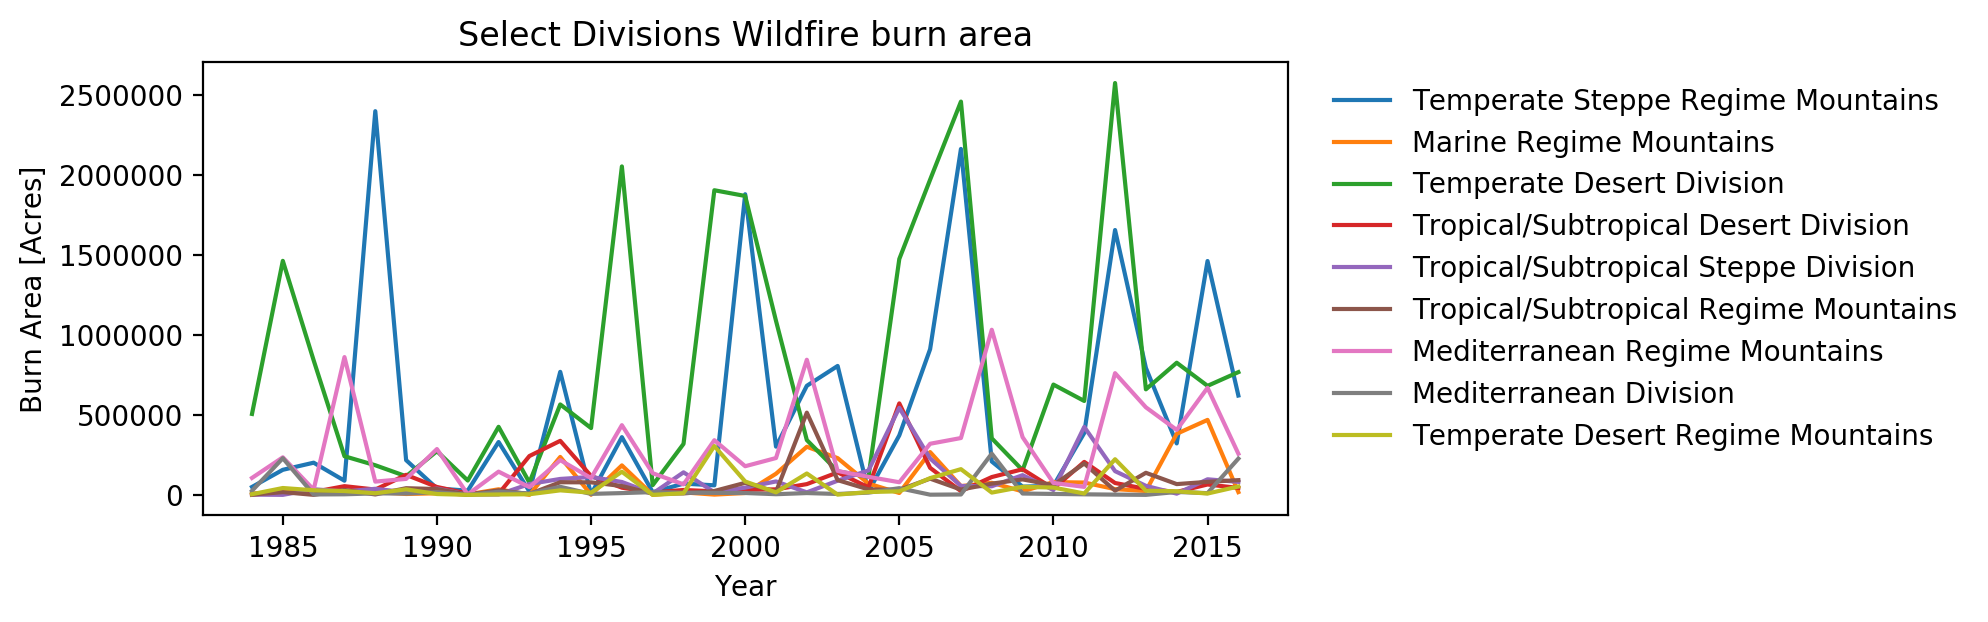

In [25]:
f, ax = plt.subplots(1, figsize=(7, 3), dpi=200)
y_seanonal_df.plot(ax=ax)
plt.title("Select Divisions Wildfire burn area")
plt.ylabel("Burn Area [Acres]")
plt.xlabel("Year")
plt.legend()

# handle the legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.14, 1, 1.5, 0.0))
leg.set_frame_on(False)

plt.show()

## Standardize the predictors (features) for seasonal burn area variance analysis
- The mean and standard deviation of the features needs to be saved in order for bias correcting CMIP5 output later. 

In [26]:
X_seasonal_dict.keys()

dict_keys(['Temperate Steppe Regime Mountains', 'Marine Regime Mountains', 'Temperate Desert Division', 'Tropical/Subtropical Desert Division', 'Tropical/Subtropical Steppe Division', 'Tropical/Subtropical Regime Mountains', 'Mediterranean Regime Mountains', 'Mediterranean Division', 'Temperate Desert Regime Mountains'])

In [62]:
# Dictionary to store DataFrames of the standardized features
Z_dict = {}

# Make DataFrames where the means and std of feature data can be saved 
# [division x feature]
X_mean_df = pd.DataFrame(index=X_seasonal_dict.keys(),
                         columns = X_seasonal_dict[list(X_seasonal_dict.keys())[0]].columns)
# [division x feature]
X_std_df = pd.DataFrame(index=X_seasonal_dict.keys(),
                        columns = X_seasonal_dict[list(X_seasonal_dict.keys())[0]].columns)

for i in divisions : 
    
    # Get the features for a division
    X = X_seasonal_dict[i]
    
    # Calculate and store in correct location, means and std
    X_mean_df.loc[i, X.mean().index] = X.mean().copy()
    X_std_df.loc[i, X.std().index] = X.std().copy()
    
    # Standardize the X feature data and store in Z_dict
    Z_dict[i] = ( (X-X.mean()) / X.std() ).copy()
    
# Save these mean and std values, they are needed for projections
X_mean_df.to_csv(os.path.join(save_dir_base, "feature_means.csv"))
X_std_df.to_csv(os.path.join(save_dir_base, "feature_std.csv"))

### Implement a custom cross validation scheme that minimizes leave one out sample error
- Use nested so that there is no data snooping and so my classifier does not estimate too high a value. 
- Alpha varies how harsh the model is, the bigger alpha, the more predictors are eliminated. When alpha = 0 Lasso is the same as OLS regression. And with this many features, it will FOR SURE be overfit. 
````Python 
for alpha value in a range(alphas) : 
    for leaving a year out: (1984:2016):
        leave_one_out_model = Lasso(alpha, these years of targets and predictors)
        
     Calculate mean error for this alpha
````

In [65]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LassoCV, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import warnings # For all kinds of converge issues

In [66]:
def get_OLS_score(Z, y) : 
    """
    Gets r-squared score for a target using a matrix of features. 
    """
    linear_model = LinearRegression()
    _ = linear_model.fit(Z, y)
    score = linear_model.score(Z, y)
    return score

def show_model_skill(z, y, model, fname, div) :
    """
    Predict historical values using optimal alphas.
    plots the following:
        1) model coeficients
        2) y vs. y_hat time series
        3) y vs. y_hat 1:1
        4) model residuals
        
        # TODO: Make into a class. 
        
    Parameters
    ----------
        y : the target values as an array
        Z : the features used to predict the target as a pd.DataFrame
        model : from LassoCV or similar, to be sumarized
        fname : image save location
    
    """
    
    years = np.array(z.index)
    
    # Make prediction
    y_hat = model.predict(z)
    
    # Setup figure 
    fig = plt.figure(dpi=200, figsize=(10,10))
    
    fig.suptitle(div + " regression summary", fontsize=14)
    
    ##########################################
    # Show the coeficients for the model_best
    ##########################################
    plt.subplot(2, 2, 1)

    plt.bar(z.columns.values, model.coef_)
    plt.axhline(y=0, c="k", linestyle="--")
    plt.xticks(rotation='vertical')
    plt.xlabel("Feature")
    plt.ylabel("Coefficients")
    plt.title("Feature coefs for least square error model, $\\alpha$=" + str(np.round(model.alpha_, 4)))

    ########################################
    # Plot obs and modeled values for both
    ########################################
    r2 = np.round(metrics.r2_score(y_true=y, y_pred=y_hat),4)
    plt.subplot(2, 2, 2)
    plt.plot(years, y, '-o', label="observation")
    plt.plot(years, y_hat, '--o', label="model")
    plt.ylabel("log$_{10}$(acres burned)")
    plt.legend()
    plt.title("Time series & mode | R$^{2}$=" + str(r2))

    ########################################
    # Plot observations vs. modeled values
    ########################################
    x1 = np.linspace( np.min([y, y_hat]), np.max([y, y_hat]) )
    r = np.round(np.corrcoef(y, y_hat)[0][1], 3)

    plt.subplot(2, 2, 3)
    plt.plot(x1, x1, color="k", linestyle=":", label="1:1")
    plt.scatter(y, y_hat, c=years)
    plt.xlabel("Observation")
    plt.ylabel("Predicted")
    plt.title("Observation vs. predicted values | r="+str(r))

    ########################################
    # Plot residuals 
    ########################################
    zero = np.zeros(len(years))
    
    plt.subplot(2, 2, 4)
    plt.scatter(years, y-y_hat, c=years)
    plt.plot(years, zero, color="k", linestyle=":")
    plt.ylabel("log$_{10}$(acres burned)")
    plt.title("Model residuals")
    plt.colorbar()
    
    plt.subplots_adjust(hspace=0.6)
    plt.savefig(fname=fname, format='png')
    plt.close()
    
def separate_predictors(atmos_vars, plant_vars, x) : 
    """
    Separates predictor DataFame (x) into plant and atmos centric predictos 
    based on the lists atmos_vars and plant_vars. 
    """
    # Clean up the symbols for precise str.contains statements 
    atmos_vars_str = str(atmos_vars).replace("'","").replace(" ","").replace(",","|").replace("[","").replace("]","|")[:-1]
    plant_vars_str = str(plant_vars).replace("'","").replace(" ","").replace(",","|").replace("[","").replace("]","|").replace("pr","pr_")[:-1]
    # make masks
    atmos_mask = np.array(pd.Series(x.columns).str.contains(atmos_vars_str))
    plant_mask = np.array(pd.Series(x.columns).str.contains(plant_vars_str))
    
    x_atmos = x.iloc[:, atmos_mask].copy()
    x_plant = x.iloc[:, plant_mask].copy()
    
    return x_atmos, x_plant

Setup the dataframe to save for plotting and analysis purposes elsewhere. 
This will be appended to the geo_divisions dataframe that was loaded when the spatial data
were first imported and plotted at the top of this notebook. 

In [67]:
results_df = geo_divisions.copy()
blank= np.full(results_df.shape[0], np.nan)

results_df['OLS_r2']   = blank.copy() # variance explained by OLS - no regularization
results_df['lasso_r2'] = blank.copy() # variances explained by lasso regression, all variables
results_df['lasso_alpha']   = blank.copy() # alpha selected by cross validation
results_df['atmos_r2']      = blank.copy() # variance explained by atmos only R-squared
results_df['plant_r2']      = blank.copy() # variance explained by plant only R-squared 

# Now this dataframe will also have information on Lasso predictor coef values
# columns for each predictor value will be placed in the loop below. 
predictors = X_seasonal_dict[list(X_seasonal_dict.keys())[0]].columns.values
for p in predictors : 
    results_df[p] = np.zeros(results_df.shape[0])

#results_df.head()

In [68]:
warnings.filterwarnings('ignore')
alphas = np.arange(0.01, 10., 0.001) # TODO: Determine the best range for ALL. 10 not large enough for sum. 

for div in divisions : 
    
    print("Training " + div)
    
    # Get division data 
    y = y_seanonal_df.loc[:,div]
    y.loc[y==0] = 1. # Need to think about if this is ok, physically wrong, or mathematically misleading. 
    y = np.log10(y.copy())
    Z = Z_dict[div]
    
    # Save OLS score
    results_df.loc[div, 'OLS_r2'] = get_OLS_score(Z, y) 
    
    # Fit a Lasso model using LOU
    lasso_model = LassoCV(alphas=alphas, cv=LeaveOneOut(), max_iter=10000, normalize=False)
    lasso_model.fit(Z, y)
    
    # Save desired output 
    results_df.loc[div, 'lasso_alpha']= lasso_model.alpha_
    results_df.loc[div, Z.columns] = lasso_model.coef_
    results_df.loc[div, 'lasso_r2'] = lasso_model.score(Z, y)
    
    #print(lasso_model.score(Z, y))
    
    # Save a plot of these results. # TODO: replace beta with informative experiment description
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + ".png")
    show_model_skill(Z, y, lasso_model, fname, div)
    
    # Repeat, but now only use either atmos or plant centric predicts, one at a time
    # save results. 
    Z_atmos, Z_plant = separate_predictors(atmos_vars, plant_vars, Z)
    
    # Fit a Lasso model using atmos only
    lasso_atmos = LassoCV(alphas=alphas, cv=LeaveOneOut(), max_iter=10000, normalize=False)
    lasso_atmos.fit(Z_atmos, y)    
    results_df.loc[div, 'atmos_r2']= lasso_atmos.score(Z_atmos, y) 
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_atmos.png")
    show_model_skill(Z_atmos, y, lasso_atmos, fname, div)
    
    # Fit a Lasso model using plant only 
    lasso_plant = LassoCV(alphas=alphas, cv=LeaveOneOut(), max_iter=10000, normalize=False)
    lasso_plant.fit(Z_plant, y)    
    results_df.loc[div, 'plant_r2']= lasso_plant.score(Z_plant, y)     
    fname = os.path.join(save_dir_base, div.replace("/"," ").replace(" ","_") + "_plant.png")
    show_model_skill(Z_plant, y, lasso_plant, fname, div)
    
    # Get rid of items to repopulate
    del(lasso_plant, lasso_atmos, lasso_model)
    # TODO: SAVE the Lasso models. 
    
warnings.filterwarnings('default')

print("Done training!")

Training Temperate Steppe Regime Mountains
Training Marine Regime Mountains
Training Temperate Desert Division
Training Tropical/Subtropical Desert Division
Training Tropical/Subtropical Steppe Division
Training Tropical/Subtropical Regime Mountains
Training Mediterranean Regime Mountains
Training Mediterranean Division
Training Temperate Desert Regime Mountains


TODO: table of coefs and mean trends from CMIP5 model would be very powerful hear, then, a final column as the number of acres increse that represents by 2050 and 2100

In [75]:
# save the results_df
# TODO: Change the name of the save directory based on 
# TODO: the conditions of this experiment run by this notebook. 
results_df.to_file(filename=os.path.join(save_dir_base, 'results_geo_df'))
results_df_ = pd.DataFrame(results_df.iloc[:,1:].copy())
results_df_.to_csv(os.path.join(save_dir_base, 'results_df.csv'))

Different divisions will need different variables, based on where coefs are greater than zero, so
different divisions will have different models and total models with availability. 

# Predict future burn area using CMIP5 data from RCP45 and RCP85
#### For a given division
- What predictors are required based on non-zero coefs? 
- Get those predictors loaded into a DataFrame [month x variable]
    - Make sure this is the same size (same # of columns and column names) as X_monthly. That way coeficients from the lasso can be applied across columns. 
- Make into seasonal predictors, ideally using make_monthly_seasonal(), exactly same method as for era-iterim data
- Repeat last two bullet-points for all available CMIP5 models. 

In [ ]:
def get_cmip5_nc(var, rcp, model, spatial_mask, spatial_mean=False):
    """
    This function will be for loading a particular CMIP5 NetCDF file, which will be spatially subset 
    by this function. These CMIP5 model output to be loaded have been regridded to the "Common grid" 
    using $ cdo remapbil. Defualts to taking the spatial mean of all global data for the var argument. 
    Change area loaded using the minX, maxX, etc. arguments. 
    
    Parameters
    ----------
        var : str, The CMIP5 variable name to be loaded. File names match variable names. 
        rcp : str, "45" or "85", refers to representative concentration pathway. 
        model : The name of the model that created the var, to be loaded from. 
        spatial_mask : numpy array, where equal to 1 (True) are locations to mask, meaning
                       they will NOT be used in calculations, spatial means, etc. 
        spatial_mean : Boolean, if False (default) the data  will be returned on a 
                       [t, lon, lat] grid. 
    
    Return
    ------
        valsCut : array[month, lat, lon] for the chosen spatial extent or 
                  array[month] spatial mean for the chosen spatial extent. 
        t_mon : array of months as pd.date_range object. 
        lon : array of longitude values that were used aftering trimming the global data
        lat : array of latitude values that were used after trimming the global data
    
    """
        
    if var == 'mrso':
        domain = 'Lmon'
    else :
        domain = 'Amon'
        
    # Create link to the monthly file in this projects directory structure. 
    dataDir = os.path.join(".." ,"Data" ,"CMIP5" ,'r1i1p1_rcp_COMMON_GRID')
    f = var + "_" + domain + "_" + model + "_rcp" + rcp + "_r1i1p1_198301-210012.nc"
    loadFile = os.path.join(dataDir, f)
    
    # Check to see if the file exists! Data logs indicate that not all requests exist
    if(not os.path.isfile(loadFile)):
        raise ValueError(f+ " File does not exist")
    
    # Load the nc data
    nc = Dataset(loadFile)
    vals = nc.variables[var][:]
    lon = nc.variables["lon"][:]
    lat = nc.variables["lat"][:]
    
    # Create a new array, where each time slice will be a masked version 
    # of the data loaded from the nc file 
    vals_masked = np.ma.empty(shape=vals.shape)
    
    # Pandas handling of time so all models have the exact same origin and such. 
    # TODO: handle required changes to this section for when historical CMIP5 data
    # TODO: are also used. 
    t = nc.variables["time"]
    if(len(t) == 1416):
        # Convert to pandas time array, on the assumption t[0]=2006-01 & t[-1]=2100-12
        t_mon = pd.date_range("1983-01-01", periods=len(t), freq="M")
    else:
        raise ValueError('Error in number of months for file: '+ f + " 1416 expected.")
        
    # Now subset the data based on the passed spatial_mask
    for i in range(len(t)) : 
        vals_masked[i,:,:] = np.ma.masked_array(vals[i,:,:], mask=spatial_mask, copy=True)
    
    # Now, take the mean value in this spatial domain. Note, the 
    # same is done to the era-interim data using the method:
    # get_era_nc_vals()
    if spatial_mean :
        spatial_mean_values = np.ma.mean(vals_masked, axis=(1,2))
        vals_masked = spatial_mean_values
        
    nc.close()
    
    return vals_masked, t_mon, lon, lat

Get an array with all possible models available. TODO: MAKE SURE LIST COMPLETE. 

In [135]:
cmip_models = []
for m in md.model_name.keys() : 
    cmip_models.append(m)
cmip_models = np.array(cmip_models)

In [120]:
# open connection to div mask nc file 
div_mask_nc = Dataset(grid_division_masks_file, 'r') # TODO: Move open and close outside of loop
grid_lat = div_mask_nc.variables['lat'][:].data
grid_lon = div_mask_nc.variables['lon'][:].data

In [198]:
# TODO: use information from next cell to keep track of what variables are needed from
# TODO: what models to make data complete. 

In [212]:
# NOTE: This will be the new make_cmip5_predictors(), make it a function 
div_CMIP_dict = {}

for div in divisions :

    print("-----------------------------------------------------")
    print(div)
    
    # Each entry in this dictionary will be the sesinak predictors 
    # in a dataframe for the division
    div_CMIP_dict[div] = {}
    
    feature_names = Z_dict[div].columns
    print("All features for " + div + ":")
    print(feature_names)
    
    div_coefs = results_df.loc[div, feature_names].copy()
    needed_features_mask = np.abs(div_coefs) > 0
    needed_features = div_coefs.index.values[needed_features_mask]
    print("needed features where np.abs(coef) > 0:")
    print(needed_features)
    
    # Get the names of the features to load without the seasonality "_season" component 
    needed_features_base = []
    for f in needed_features :
        s_loc = f.find("_")
        needed_features_base.append(f[:s_loc])
    needed_features_base = np.array(np.unique(needed_features_base))
    print("Names of needed features before seasonal average")
    print(needed_features_base)

    # Get grid boxes to mask. Note: line below will be True for grid boxes to mask
    # i.e. not use. 
    div_mask = div_mask_nc.variables[div.replace("/", " ")][:].data == 0

    # Now we have to loop over models, all common features set 
    for cmip_model in cmip_models :
        
        # Create empty dataframe for 
        monthly_df = pd.DataFrame(index=range(1416), columns=needed_features_base)
        
        # Keep track of how many variables are available
        var_count = 0
        
        # Loop over needed variables to create the [month x feature] DataFrame
        for var in needed_features_base :
            
            try :
                
                vals_masked, t_mon, _, _ = get_cmip5_nc(var, "85", cmip_model, div_mask, spatial_mean=True)
                monthly_df.loc[:,var] = np.array(vals_masked)
                # TODO: keep track of what models have all needed predictors for each region. 
                var_count += 1

            except ValueError :
                
                print("Unable to load " + var + " for " + cmip_model)
            
            # Only all base features were available. make monthly_df seasonal feature 
            # DataFrame
            if var_count == len(needed_features_base) : 
            
                monthly_df.index = t_mon
                # TODO: Make the datafrane returned here have the same columns and dimensions
                # TODO: and order as Z_dict dataframes that trained the lasso. That way the 
                # TODO: model.predict() will be much easier. Leave not needed columns as zeros or nans. 
                div_CMIP_dict[div][cmip_model] = make_monthly_seasonal(monthly_df, t_mon)
                print("All variables needed available.")
                print("var count " + str(var_count) + " and length " + str(len(needed_features_base)))
        
        del(monthly_df, var_count)

-----------------------------------------------------
Temperate Steppe Regime Mountains
All features for Temperate Steppe Regime Mountains:
Index(['tas_winter', 'tas_spring', 'tas_summer', 'pr_winter', 'pr_spring',
       'pr_summer', 'sfcWind_winter', 'sfcWind_spring', 'sfcWind_summer',
       'hurs_winter', 'hurs_spring', 'hurs_summer', 'hfls_winter',
       'hfls_spring', 'hfls_summer', 'VPD_winter', 'VPD_spring', 'VPD_summer',
       'mrso_winter', 'mrso_spring', 'mrso_summer', 'evspsbl_winter',
       'evspsbl_spring', 'evspsbl_summer'],
      dtype='object')
needed features where np.abs(coef) > 0:
['tas_spring' 'tas_summer' 'hurs_summer' 'VPD_spring' 'VPD_summer']
Names of needed features before seasonal average
['VPD' 'hurs' 'tas']
All variables needed available.
var count 3 and length 3
All variables needed available.
var count 3 and length 3
All variables needed available.
var count 3 and length 3
Unable to load VPD for CCSM4
Unable to load hurs for CCSM4
Unable to load tas fo

In [215]:
# Write
with open(os.path.join(save_dir_base,'rcp85_features.obj'), 'wb') as fp:
    pickle.dump(div_CMIP_dict, fp)

In [206]:
# Read
with open(os.path.join(save_dir_base,'rcp85_features.obj'), 'rb') as fp:
    banana = pickle.load(fp)

Code below will be deleted. It has been replaced with new loops above. 

In [36]:
def make_cmip5_predictors(rcp, spatial_mask, var_dict) :
    """
    This function needs to be double checked.
    Then I need to document its methods, parameters, and returns, here. 
    """
        
    # Store all models output for a scenario in dictionary
    futures = {}

    # Create a path to the data
    cmip5_dir = os.path.join("..","Data","CMIP5","r1i1p1_rcp_COMMON_GRID")

    # Create an array to check if a given cmip5 model has all required output. 
    # This changes depending on what parameters the lasso says are needed. 
    data_available_mask = []

    for model_name in md.model_name.keys() : # ['ACCESS1-0', 'ACCESS1-3'] :

        print("Loading data for model: " + model_name)

        # Check to see if all needed variables exist before 
        file_exists = []
        for var in var_dict :
            if var == 'mrso' :
                DT = '_Lmon_'
            else : 
                DT = "_Amon_"
                
            ext = var + DT + model_name+"_"+"rcp"+rcp+"_r1i1p1_198301-210012.nc"
            f = os.path.join(cmip5_dir, ext)
            exists = os.path.exists(f)
            file_exists.append(exists)
        
        #print("Checked the model for all needed varialbles")
        #print(file_exists)
        
        # If all in file_exists are true, get the data. 
        if np.sum(file_exists) == len(file_exists) :

            # Temp storage for model output
            model_dict = {} 
            for var in var_dict :

                # Until I re-clean the data, check to make sure it loads 
                try :
                    # Get the values for this model, scenario, and variable
                    var_vals, cmip_t, cmip_lon, cmip_lat = get_cmip5_nc(var, rcp, model_name, 
                                                                        spatial_mask, 
                                                                        spatial_mean=True)
                    # Store the values
                    model_dict[var] = var_vals

                except ValueError:
                    print("unable to load " + var)

            # Convert to a pd.DataFrame for easier handling
            model_monthly = pd.DataFrame(model_dict)

            # Convert to seasonal predictors. 
            model_seasonal = months_to_seasonal(df=model_monthly, t=cmip_t)
            futures[model_name] = model_seasonal

        else :
            missing_mask = False == np.array(file_exists)
            print("Skipped " + model_name + " not all variables available. ")
            print(np.array(var_dict)[np.array(missing_mask)])
            print("--------------------------------------------------------")
            # TODO: Print the variables that are missing. Maybe there is hope?
        
    # Columns are no longer months, they are years. 
    cmip_years = np.sort(np.unique(cmip_t.year))
            
    return futures, cmip_years

In [39]:
# If the Lasso chooses all predictors
var_dict = era_features.columns
#cmip_features

print("Getting RCP 8.5")
futures85, cmip_years = make_cmip5_predictors("85", spatial_mask, var_dict)

Getting RCP 8.5
Loading data for model: ACCESS1-0
Skipped ACCESS1-0 not all variables available. 
['t2m' 'tp' 'si10' 'RH' 'slhf' 'e']
--------------------------------------------------------
Loading data for model: ACCESS1-3
Skipped ACCESS1-3 not all variables available. 
['t2m' 'tp' 'si10' 'RH' 'slhf' 'e']
--------------------------------------------------------
Loading data for model: CanESM2
Skipped CanESM2 not all variables available. 
['t2m' 'tp' 'si10' 'RH' 'slhf' 'e']
--------------------------------------------------------
Loading data for model: CCSM4
Skipped CCSM4 not all variables available. 
['t2m' 'tp' 'si10' 'RH' 'slhf' 'VPD' 'mrso' 'e']
--------------------------------------------------------
Loading data for model: CMCC-CESM
Skipped CMCC-CESM not all variables available. 
['t2m' 'tp' 'si10' 'RH' 'slhf' 'VPD' 'mrso' 'e']
--------------------------------------------------------
Loading data for model: CMCC-CM
Skipped CMCC-CM not all variables available. 
['t2m' 'tp' 'si10

UnboundLocalError: local variable 'cmip_t' referenced before assignment

In [ ]:
print("Getting RCP 4.5")
futures45, cmip_years = make_cmip5_predictors("45", spatial_mask, var_dict)

In [ ]:
print("There are %i models avaialble for rcp 85 " % len(futures85.keys()) )
print("There are %i models avaialble for rcp 45 " % len(futures45.keys()) )
for m in futures45.keys() : 
    print(np.sum(futures45[m].columns == era_features.columns))

### Unit sanity checks for variables where different units are stored for ERA-Interim and CMIP5. 
- This also serves as a sanity check on the unit conversion. 

In [ ]:
plt.figure(figsize=(10,6), dpi=150)

ax=plt.subplot(111)

for model in futures85.keys() :
    plt.hist(futures85[model].loc[:,"pr_summer"].values, density=True, label=model, alpha=0.3)

plt.hist(era_features['pr_summer'].values, density=True, label="ERA-Interim 1984-2016", alpha=0.8)

plt.xlabel("kg m$^{-2}$ s$^{-1}$")
plt.title("Summer Precip Density distributions")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="RCP8.5 | 1984-2100")

plt.show()

In [ ]:
plt.figure(figsize=(10,6), dpi=150)

ax=plt.subplot(111)

for model in futures85.keys() :
    plt.hist(futures85[model].loc[:,"evspsbl_summer"].values, density=True, label=model, alpha=0.3)

plt.hist(era_features['evspsbl_summer'].values, density=True, label="ERA-Interim 1984-2016", alpha=0.8)

plt.xlabel("kg m$^{-2}$ s$^{-1}$")
plt.title("Summer Evaporation density distributions")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="RCP8.5 | 1984-2100")

plt.show()

In [ ]:
plt.figure(figsize=(10,6), dpi=150)

ax=plt.subplot(111)

for model in futures85.keys() :
    plt.hist(futures85[model].loc[:,"hfls_summer"].values, density=True, label=model, alpha=0.3)

plt.hist(era_features['hfls_summer'].values, density=True, label="ERA-Interim 1984-2016", alpha=0.8)

plt.xlabel("W m$^{-2}$")
plt.title("Summer Latent Heat flux density distributions")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="RCP8.5 | 1984-2100")

plt.show()

### Make predictions using CMIP5 model output. One prediction per model per scenario. 
#### Here is what has to happen to predict future burn area using CMIP output

- The bias of each CMIP5 model needs to be addressed. This will be done via the following equation

$$x_{bias-corrected_{CMIP5}}=(x_{CMIP5_{2006-2100}}-\overline{x_{CMIP5_{2006-2100}}})+\overline{x_{historical_{2006-2015}}}$$

This replaces the CMIP5 bias with the historical bias. This should make it so that a time series of the historical value and the projected value are roughly aligned in the first decade of the 21st century. 

- CMIP5 model variables  need to be standardized using the following equation (where x is some variable). 

$$x\prime=\frac{x_{bias-corrected_{CMIP5}}-\overline{x_{historical}}}{\sigma_{historical}}$$

- $x\prime$ is the matrix that will be fed into the trained linear model's $predict()$ methed to estimate future wildfire burn area. 

- This about what version of the historical data needs to be plotted along side the projected values using the trained regressions. 

### Standardize CMIP5 output using historical variance and mean

In [ ]:
def cmip_bias_correction(cmip5_df_features, era_df_features, feature) :
    """
    This function corrects the bias in CMIP5 seasonal output by using the 
    overallping years between CMIP5 output and era-reanalysis data. This is
    done by removing the 1984-2016 mean value of the cmip5 feature of interest
    and replacing it with the same years mean value from the reanlaysis data. 
    
    Parameters
    ----------
        cmip5_df_features : A pd.DataFrame of cmip5 features. [year x feature]
        era_df_features : A pd.DataFrame of era-interim features. [year x feature]. 
                          Must have the exact same names as cmip5_df_features. 
        feature : The feature (variable, predictor, what have you) to be bias 
                  corrected. 
    Return
    ------
        A np.array(dtype=float) of the cmip5 feature data array where the bias
        has been corrected. 
    """

    # Take the overlapping time period mean values for era and cmip
    era_overlap_mean = np.array(era_df_features.loc[2006:2015, feature]).mean()
    cmip5_overlap_mean = np.array(cmip5_df_features.loc[2006:2015, feature]).mean()
    
    # Remove the CMIP5 mean value
    cmip_feature_no_bias = np.array(cmip5_df_features[feature]) - cmip5_overlap_mean
    # Replace the CMIP5 mean value with the reanalysis mean value 
    cmip_feature_with_era_bias = cmip_feature_no_bias + era_overlap_mean
    
    return cmip_feature_with_era_bias

### Demonstration of bias correction method

In [ ]:
cmip_feature_with_era_bias = cmip_bias_correction(futures85['ACCESS1-0'], era_features, "tas_summer")

plt.figure(dpi=150)
plt.plot(era_years, era_features["tas_summer"], label="ERA-Interim")
plt.plot(cmip_years, futures85['ACCESS1-0']["tas_summer"].values, label="8.5")
plt.plot(cmip_years, cmip_feature_with_era_bias, label="8.5 bias corrected")
plt.ylabel("mean summer temperature [K]")
plt.xlabel("Year")
plt.title("CMIP5 output bias correction method visualization")
plt.axvline(1984, c='k', label="bias correction overlap")
plt.axvline(2016, c='k')
plt.legend()
plt.show()

In [ ]:
cmip_feature_with_era_bias = cmip_bias_correction(futures85['ACCESS1-0'], era_features, "evspsbl_summer")

plt.figure(dpi=150)
plt.plot(era_years, era_features["evspsbl_summer"], label="ERA-Interim")
plt.plot(cmip_years, futures85['ACCESS1-0']["evspsbl_summer"].values, label="8.5")
plt.plot(cmip_years, cmip_feature_with_era_bias, label="8.5 bias corrected")
plt.ylabel("mean summer temperature [K]")
plt.xlabel("Year")
plt.title("CMIP5 output bias correction method visualization")
plt.axvline(1984, c='k', label="bias correction overlap")
plt.axvline(2016, c='k')
plt.legend()
plt.show()

### Standardize the CMIP5 output and handle bias. 
- TODO: handle trends within the overlap period. This could be important if sigma is driven by a trend rather than year to year variability.

In [ ]:
print(era_features.columns)
print(futures85["ACCESS1-0"].columns)

In [ ]:
def standardize_cmip(cmip_dict, era_df_features) : 
    """
    Standardizes historical output using era reanlysis data fields. The 
    cmip5 model output bias is first corrected using cmip_bias_correction()
    then then standardized using historical (1984-2016) variance and width. 
    
    Parameters
    ----------
        cmip5_dict : A dictionary of CMIP5 output in pd.DataFrames. This 
                     function will loop over these models creating Z. 
        era_df_features : a pd.Dataframe of era features. Must exactly match
                          the features (columnames) in cmip5_dict dataframes. 
                          ERA feature means and standard deviations are 
                          calculated using this dataframe. 
                          
        Return
        ------
            A dictionary of pd.Dataframe where the keys are cmip5 model names
            and the values are the features standarized using historical (era)
            mean and variance. 
    """
    #print("--------------------")
    #print("Standardizing output")
    #print("--------------------")
    
    # Don't want any changes to be made outside of function 
    era_df_features = era_df_features.copy()
    
    # Get the mean and std values of the era_df_features to use to standardize 
    # the cmip model output by
    era_ref_mean = era_df_features.mean().copy()
    era_ref_std  = era_df_features.std().copy()
    
    # A dictionary to store the standardized output 
    Z_futures_dict = {}
    
    # Get model names to loop over 
    model_names = cmip_dict.keys()
    n_models = len(model_names) 

    for model_name in model_names : 

        #print("Standardizing %s model output" % model_name)

        # Get the Cmip5 features dataframe fromt the futures dict.
        cmip5_df_features = cmip_dict[model_name].copy()
        cmip_years = np.array(cmip5_df_features.index.values)
        features = cmip5_df_features.columns.values

        # np.array to store standardized values 
        Z_future = np.zeros(shape=cmip5_df_features.shape)
        # Convert the np.array to a pd.DataFrame for nice storage. 
        Z_future_df = pd.DataFrame(Z_future, columns=features, index=cmip_years)

        # Standardize (using historical mean and variance) 
        # the columns of these CMIP5 output 
        for feature in features : 

            #print("feature being standardized: %s" % feature)

            # Handle bias
            feature_bias_corrected = cmip_bias_correction(cmip5_df_features, era_df_features, feature)

            # Standardize with historical values
            Z_future_df.loc[:,feature] = (feature_bias_corrected - era_ref_mean[feature]) / era_ref_std[feature]
            #f feature == 'evspsbl_summer' :
            #   print(feature)
            #   print("Mean %f" % era_ref_mean[feature])
            #   print("std %f" % era_ref_std[feature] )
            #   print( (feature_bias_corrected - era_ref_mean[feature]) / era_ref_std[feature] )
        
        # Store in the dictionary
        Z_futures_dict[model_name] = Z_future_df
        
    #print("--------------------")
    #print("Output standardized")
    #print("--------------------")        
    
    return Z_futures_dict

Standardize the features 

In [ ]:
Z_futures85_dict = standardize_cmip(futures85, era_features)
Z_futures45_dict = standardize_cmip(futures45, era_features)

Make z a pd.DataFrame Z, easier to plotting and handling

In [ ]:
Z = pd.DataFrame(z, index=era_features.index.values, columns=era_features.columns.values)

### Plot Z time series to make sure standardization and bias correction worked as estimated 

In [ ]:
def plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, feature) : 
    """
    Z : pd.DataFrame, the standardized era-interim fields 
    Z_futures85_dict : pd.DataFrame, the standardized CMIP5 RCP85 fields
    Z_futures45_dict : pd.DataFrame, the standardized CMIP5 RCP45 fields
    feature : str, the feature in the passed dataframes to plot 
    
    """
    
    fig = plt.figure(dpi=200)

    ax = plt.subplot(111)
    
    for i in Z_futures85_dict.keys() : 
        plt.plot(cmip_years, Z_futures85_dict[i][feature].values, c="r", alpha=0.5)#, label="RCP 8.5")
        if np.max(Z_futures85_dict[i][feature].values) > 1000 : 
            print("model with wack values is: " + i)
        
    for j in Z_futures45_dict.keys() : 
        plt.plot(cmip_years, Z_futures45_dict[j][feature].values, c="blue", alpha=0.5)#, label="RCP 4.5")
        if np.max(Z_futures45_dict[j][feature].values) > 1000 : 
            print("model with wack values is: " + j)
        
    # Place the historical record on at the end. 
    y = Z[feature].copy()
    plt.plot(np.array(Z.index.values), y, c="k", linewidth=3)#, label="ERA-Interim")
    #ymin = np.min(y) - 5. * np.std(y)
    #ymax = np.max(y) + 10. * np.std(y)
    #plt.ylim([ymin, ymax])
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #plt.legend(loc='best')
    
    plt.xlabel("Year")
    plt.ylabel(feature + "historical [$\sigma$]")
    plt.title(feature)
    plt.show()

Plot everything used in this analysis. 

In [ ]:
for f in Z.columns.values :
    plot_history_future(Z, Z_futures85_dict, Z_futures45_dict, f)

### Save all correlations and variance explained
- These go to to mapped_correlations.ipynb

In [ ]:
# save the divisions geodataframe
# TODO: save these at the end of this script, where correlations for all regions for all 
# TODO: predictors are saved for each division. Synthetic for now. 
#df_divisions = pd.DataFrame(geo_divisions.drop(columns='geometry'))
print(type(geo_divisions))

for p in predictors : 
    geo_divisions[p] = np.random.uniform(low=-1., high=1., size=geo_divisions.shape[0]) 

# Now we need plant and atmos R-squared values
geo_divisions['atmos_r-squared'] = np.random.uniform(low=0, high=1., size=geo_divisions.shape[0]) 
geo_divisions['plant_r-squared'] = np.random.uniform(low=0, high=1., size=geo_divisions.shape[0])

print(geo_divisions.index)
geo_divisions.to_file(filename='../Data/Analysis/division_geometries')

### Use the standardized CMIP output to make predictions using the trained linear classifier

In [ ]:
lasso_model.coef_

In [ ]:
def calculate_future_BA(m, Z_futures_dict) :
    """
    m : The trained Lasso Model  
    Z_futures_dict : pd.DataFrame, CMIP5 model output in units of historical variance. 
    """
    # Dictionary to store the df of predictions
    BA_future_dict = {}
        
    for cmip_model in Z_futures_dict.keys() : 

        # Use the trained classifier to make a prediction
        Z_pred_features =  Z_futures_dict[cmip_model].copy() 
        BA_future_dict[cmip_model] = m.predict(np.array(Z_pred_features))
        
    # Make into a DataFrame.
    burn_area_df = pd.DataFrame(BA_future_dict, index=Z_pred_features.index.values)
        
    del BA_future_dict
    
    return burn_area_df

In [ ]:
RCP_85_burn_areas = calculate_future_BA(lasso_model, Z_futures85_dict)
RCP_45_burn_areas = calculate_future_BA(lasso_model, Z_futures45_dict)
historic_burn_area = lasso_model.predict(z)

#### Show burn area projections

In [ ]:
fig = plt.figure(dpi=200)

ax = plt.subplot(111)

plt.plot(RCP_85_burn_areas, alpha=0.1, color='gray')
plt.plot(RCP_45_burn_areas, alpha=0.1, color='gray')


RCP_85_burn_areas.mean(axis=1).plot(label="RCP 8.5 mean", linewidth=3)
RCP_45_burn_areas.mean(axis=1).plot(label="RCP 4.5 mean", linewidth=3)
plt.plot(era_years, historic_burn_area, label="ERA-Interim", linewidth=3)
plt.scatter(era_years, y, label="MTBS Burn Area", c='k')
plt.legend()
plt.ylabel("$log_{10}$(Acres Burned)")
plt.title("")


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

Sorry trees. 